In [42]:
import os
import pandas as pd
import numpy as np
from scipy.stats import mode

In [43]:
%matplotlib inline
%config InlineBackend.rc={'figure.figsize': (12, 8)}

In [44]:
# Params

especific_exam = '25080125_08_2019_08_32_38_label'

len_list_calc_normal = 40
len_list_calc_focus = 15

thresould_quantile = 1.5
jump_after_stimulus = 50

outlier_loop = 1
alter_to = 'median' # ['mode', 'median']

In [45]:
path_labels = '/media/marcos/Dados/Projects/Results/PupilDeep/Labels'
path_out = '/media/marcos/Dados/Projects/Results/PupilDeep/Labels/process'
path_information = '/media/marcos/Dados/Projects/Datasets/exams/informations_exams'
path_log = '{}/log.txt'.format(path_out)

In [46]:
list_labels = []
if especific_exam == '':
    for files in os.listdir(path_labels):
        if '_label.csv' in files:
            list_labels.append(files)
else:
    exam = '{}.csv'.format(especific_exam)
    if exam in os.listdir(path_labels):
        list_labels.append(exam)
    else:
        raise Exception('Not found especific exam!')

print(list_labels)

['25080125_08_2019_08_32_38_label.csv']


In [47]:
def create_csv_out(label):
    file_in = '{}/{}'.format(path_labels, label)
    file_out = '{}/{}'.format(path_out, label)
    
    with open(file_in, 'r') as csv_in:
        with open(file_out, 'a') as csv_out:
            for line in csv_in.readlines():
                if 'Execition' not in line:
                    csv_out.write(line)

In [48]:
def make_path(path):
    try:
        os.mkdir(path)
    except FileExistsError:
        pass

In [120]:
def remove_labels(path_out):
    try:
        for file in os.listdir(path_out):
            remove = '{}/{}'.format(path_out, file)
            print(remove)
            os.remove(remove)
    except OSError as e:
        #pass
        print("Failed with:", e.strerror) # look what it says
        print("Error code:", e.code)

In [121]:
def outlier_treatment_loop(dataset):
    Q1 = dataset['radius'].quantile(0.25)
    Q3 = dataset['radius'].quantile(0.75)
    IQR = Q3 - Q1    
    
    tq = thresould_quantile
    filter_q = (dataset['radius'] >= Q1 - tq * IQR) & (dataset['radius'] <= Q3 + tq * IQR)
    filter_q = [frame for frame, avaliable in filter_q.iteritems() if not avaliable]
    
    for frame in  filter_q:
        list_radius = np.array([])
        list_radius = dataset.loc[frame:frame+len_list_calc_normal].radius
        dataset['radius'][frame] = int(np.median(list_radius))
    
    return dataset

In [122]:
def outlier_treatment(dataset):
    for i in range(outlier_loop):
        log = 'loop outlier treatment: {}'.format(i)
        save_log(log)
        dataset = outlier_treatment_loop(dataset)
    
    return dataset

In [123]:
def treat_dataset(dataset):
    init_range, end_range = get_range_flash(dataset)
    
    aux = 0
    for i in range(0, len(init_range)):        
        flash_dataset = dataset.loc[init_range[i]:end_range[i]]
        work_dataset = dataset.loc[aux:init_range[i]-1]
        
        frames_mod = mode(work_dataset['radius'])[0][0]
        frames_median = work_dataset['radius'].median()
        new_radius = frames_mod if alter_to == 'mode' else frames_median
        
        for index, item in flash_dataset.iterrows():
            dataset['radius'][index] = new_radius
                
        for index, item in work_dataset.iterrows():
            len_list = len_list_calc_normal
            if index > init_range[0]:
                if index <= aux + jump_after_stimulus:
                    len_list = len_list_calc_focus
                    
            range_dataset = work_dataset.loc[index:index+len_list]
            frames_mod = mode(range_dataset['radius'])[0][0]
            frames_median = range_dataset['radius'].median()
            new_radius = frames_mod if alter_to == 'mode' else frames_median
            dataset['radius'][index] = new_radius
        
        aux = end_range[i]+1
    
    return dataset

In [124]:
def extract_important_information(dataset):
    
    new_dataset = {[]}

In [125]:
def get_range_flash(dataset):
    filter_flash = dataset['flash'] > 0
    frames_flash = [frame for frame, avaliable in filter_flash.iteritems() if avaliable]    
    
    init_range = [frames_flash[0]]
    end_range = []
    
    for i in range(0, len(frames_flash)-1):
        if frames_flash[i]+1 != frames_flash[i+1]:
            end_range.append(frames_flash[i])
            init_range.append(frames_flash[i+1])
            
    end_range.append(frames_flash[len(frames_flash)-1])
    
    return init_range, end_range

In [126]:
def save_log(log):
    with open(path_log, 'a') as file_out:
        file_out.write('{}\n'.format(log))    

In [127]:
def plot_graph(dataset, title):
    title_graph = '{}\nlsrn: {}, lsrf: {}, tq: {}, ol: {}, at: {}, '.format(
        title, len_list_calc_normal, len_list_calc_focus, thresould_quantile, outlier_loop, alter_to)
    
    img = dataset.plot.line(x='frame', y='radius', linestyle='-', markevery=100, marker='o', title=title_graph)
    img.figure.savefig('{}/{}.pdf'.format(path_out, title.replace('.csv', '')))

   frame  center_x  center_y  radius  flash  eye_size    img_mean    img_std
0      0       273       252      48      0         0  128.101331  71.663002
1      1       266       237      57      0         0  128.141810  71.605758
2      2       267       250      48      0         0  128.153053  71.501207
3      3       263       254      49      0         0  128.134134  71.548998
4      4       258       247      57      0         0  128.129733  71.526607


/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/marcos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   frame  center_x  center_y  radius  flash  eye_size    img_mean    img_std
0      0       273       252      55      0         0  128.101331  71.663002
1      1       266       237      55      0         0  128.141810  71.605758
2      2       267       250      54      0         0  128.153053  71.501207
3      3       263       254      54      0         0  128.134134  71.548998
4      4       258       247      54      0         0  128.129733  71.526607


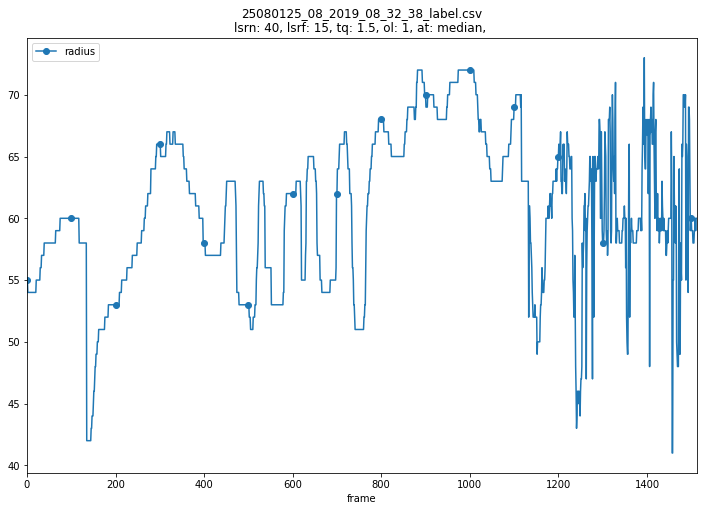

In [133]:
path_out = '{}/process'.format(path_labels)

make_path(path_out)
remove_labels(path_out)

for label in list_labels:
    create_csv_out(label)

    file_in = '{}/{}'.format(path_out, label)
    file_out = '{}/process_{}'.format(path_out, label)

    dataset = pd.read_csv(file_in)    
    print(dataset.head())

    dataset = outlier_treatment(dataset)
    dataset = treat_dataset(dataset)

    print(dataset.head())    

    plot_graph(dataset, label)

    dataset.to_csv(file_out, index = False, header=True)